In [ ]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/tweet_emotion_dataset.xlsx'

df = pd.read_excel(path,sheet_name='Sheet1')
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Tweet,Label
0,Thinks that @melbahughes had a great 50th birt...,surprise
1,"Como una expresiÃ³n tan simple, una sola oraci...",sadness
2,the moment when you get another follower and y...,joy
3,Be the greatest dancer of your life! practice ...,joy
4,eww.. my moms starting to make her annual rum ...,disgust


In [ ]:
df.groupby('Label').Label.count()

Label
anger       1555
disgust      761
fear        2816
joy         8240
sadness     3830
surprise    3849
Name: Label, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21051 entries, 0 to 21050
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   20248 non-null  object
 1   Label   21051 non-null  object
dtypes: object(2)
memory usage: 329.0+ KB


In [ ]:
# remove null values

df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20248 entries, 0 to 21050
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   20248 non-null  object
 1   Label   20248 non-null  object
dtypes: object(2)
memory usage: 474.6+ KB


In [ ]:
df.groupby('Label').Label.count()

Label
anger       1506
disgust      719
fear        2725
joy         8028
sadness     3608
surprise    3662
Name: Label, dtype: int64

In [ ]:
# tweets pre-processing 

import re


def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text


def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\:"
                               u"\;"
                               u"\_"
                               u"\("
                               u"\)"
                               u"\u0153"
                               u"\u231a"
                               u"\u017e"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u200c"
                               u"\u2300-\u23ff"
                               u"\u2066"
                               u"\u2067"
                               u"\u2069"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



df['Tweet'] = df['Tweet'].apply(preprocessor)
df['Tweet'] = df['Tweet'].apply(strip_links)
df['Tweet'] = df['Tweet'].apply(remove_emoji)

In [ ]:
df.loc[20]

Tweet    large crowds of manic football fans amp mascots 
Label                                                fear
Name: 20, dtype: object

## Experiments on un-balanced dataset 

In [ ]:
# Vectorization 

max_words = 20000
maxlen = 20
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Tweet'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 30440 unique tokens.


In [ ]:
sequences = tokenizer.texts_to_sequences(df['Tweet'])
X= pad_sequences(sequences, maxlen=maxlen)
X.shape

(20248, 20)

In [ ]:
# convert labels into numbers
Y = pd.get_dummies(df['Label']).values 
Y.shape

(20248, 6)

In [ ]:
# split Dataset 90% for train and 10% for test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [ ]:
# load Glove twitter word embedding

import os, shutil

wp = '/content/drive/MyDrive/MS/Sem - 03/deep learning/word embedding'

embeddings_index = {}
f = open(os.path.join(wp, 'glove.twitter.27B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 100)           2000000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 2,017,222
Trainable params: 2,017,222
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
# Training and evaluation
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
18223/18223 [==============================] - 12s 639us/step - loss: 1.5188 - acc: 0.4124
Epoch 2/30
18223/18223 [==============================] - 11s 618us/step - loss: 1.4224 - acc: 0.4509
Epoch 3/30
18223/18223 [==============================] - 12s 647us/step - loss: 1.3648 - acc: 0.4770
Epoch 4/30
18223/18223 [==============================] - 11s 601us/step - loss: 1.3193 - acc: 0.4960
Epoch 5/30
18223/18223 [==============================] - 11s 619us/step - loss: 1.2777 - acc: 0.5150
Epoch 6/30
18223/18223 [==============================] - 11s 607us/step - loss: 1.2430 - acc: 0.5299
Epoch 7/30
18223/18223 [==============================] - 11s 606us/step - loss: 1.2095 - acc: 0.5443
Epoch 8/30
18223/18223 [==============================] - 11s 629us/step - loss: 1.1799 - acc: 0.5575
Epoch 9/30
18223/18223 [==============================] - 12s 651us/step - loss: 1.1520 - acc: 0.5689
Epoch 10/30
18223/18223 [==============================] - 11s 610us/step - loss: 

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2025/2025 [==============================] - 1s 292us/step
Test set
  Loss: 1.662
  Accuracy: 0.494


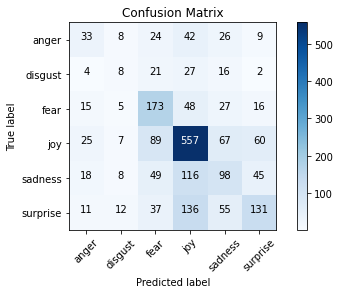

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

labels = ['anger','disgust','fear','joy','sadness','surprise']

y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=matrix, classes=labels, title='Confusion Matrix')

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

       anger       0.31      0.23      0.27       142
     disgust       0.17      0.10      0.13        78
        fear       0.44      0.61      0.51       284
         joy       0.60      0.69      0.64       805
     sadness       0.34      0.29      0.31       334
    surprise       0.50      0.34      0.41       382

    accuracy                           0.49      2025
   macro avg       0.39      0.38      0.38      2025
weighted avg       0.48      0.49      0.48      2025



## Text generation to balance the dataset

In [ ]:
df.head()

,Tweet,Label
0,Thinks that @melbahughes had a great 50th birt...,surprise
1,"Como una expresiÃ³n tan simple, una sola oraci...",sadness
2,the moment when you get another follower and y...,joy
3,Be the greatest dancer of your life! practice ...,joy
4,eww.. my moms starting to make her annual rum ...,disgust


In [ ]:
df.groupby('Label').Label.count()

Label
anger       1506
disgust      719
fear        2725
joy         8028
sadness     3608
surprise    3662
Name: Label, dtype: int64

**For anger class**

In [ ]:
anger = df[df['Label']=='anger']
len(anger)

1506

In [ ]:
anger_text = anger['Tweet']

In [ ]:
anger_text = list(anger_text)

In [ ]:
with open('anger.txt', 'w') as filehandle:
    for listitem in anger_text:
        filehandle.write('%s\n' % listitem)

In [ ]:
text = anger['Tweet'].str.lower()

max tweet len: 145
min tweet len: 20


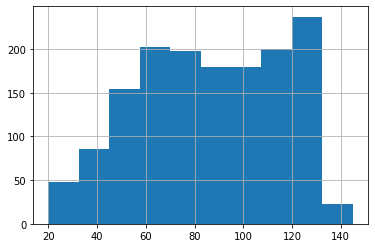

In [ ]:
print('max tweet len:',text.map(len).max())
print('min tweet len:',text.map(len).min())
text.map(len).hist();

In [ ]:
maxlen = 40
step = 1
sentences = []
next_chars = []
for x in text:
    for i in range(0, len(x) - maxlen, step):
        sentences.append(x[i: i + maxlen])
        next_chars.append(x[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 70720


In [ ]:
## check example
for i in range(10):
    print(sentences[i],'==>',next_chars[i])

soooo dooowwwn move on get some sleep me ==>  
oooo dooowwwn move on get some sleep me  ==> d
ooo dooowwwn move on get some sleep me d ==> e
oo dooowwwn move on get some sleep me de ==> s
o dooowwwn move on get some sleep me des ==> e
 dooowwwn move on get some sleep me dese ==> r
dooowwwn move on get some sleep me deser ==> v
ooowwwn move on get some sleep me deserv ==> e
oowwwn move on get some sleep me deserve ==>  
owwwn move on get some sleep me deserve  ==> b


**text genertion using textgenrnn LSTM base model**

In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
pip install textgenrnn

In [ ]:
from textgenrnn import textgenrnn

textgen = textgenrnn()
textgen.generate()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

[Highlight] I did it!!!



In [ ]:
textgen.train_from_file("/content/anger.txt", num_epochs=20)

1,554 texts collected.
Training on 137,826 character sequences.
Epoch 1/20
1076/1076 [==============================] - 16s 15ms/step - loss: 1.9105
####################
Temperature: 0.2
####################
@Jendyanderan #Charlickest #anger

@Janskanyne @Jausulanting @JJJJJZZZZYYOONORY #CLA #from #Fan #SOLLY #MAYA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

I hate the people that we hate to stupping me to see it when you stupping me to the complete house to the person on the season on the shitting that I hate that I hate the situation and can be so ballowing to they come to the serially one of the company #anger #freel

####################
Temperature: 0.5
####################
I feel like I want to stupping me that a song and this is some some days now. #Friedded

I see they manage my paid teacher about it on the phone I want to them. 

@Jenddatveratos #For death #from #Mingound ##angerteray. #happenders

In [ ]:
import os 
os.rename('textgenrnn_weights.hdf5', 'anger_textgenrnn_weights.hdf5')
from google.colab import files
files.download('anger_textgenrnn_weights.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
textgen = textgenrnn('/content/anger_textgenrnn_weights.hdf5')
#after doing all the training work
textgen.generate_to_file('genrated_anger.txt', n=6522)

**For disgust class**

In [ ]:
disgust = df[df['Label']=='disgust']
disgust_text = disgust['Tweet']
disgust_text = list(disgust_text)

with open('disgust.txt', 'w') as filehandle:
    for listitem in disgust_text:
        filehandle.write('%s\n' % listitem)



textgen.train_from_file("/content/disgust.txt", num_epochs=20)
import os 
os.rename('textgenrnn_weights.hdf5', 'disgust_textgenrnn_weights.hdf5')

718 texts collected.
Training on 63,824 character sequences.
Epoch 1/20
498/498 [==============================] - 7s 15ms/step - loss: 2.0055
####################
Temperature: 0.2
####################
I hate the forgoth for a good who can't see it and they are started a good and they are a someone every a bitch of the situal and the way of the way of the for a more is a fan that they are someone even they are a fucking the game and they are a picture before the people and they are a fuck and an

I was a seed and they're a fuck of showed that someone was a poop of a bitch of a shit and they're a bitch in a period when you are a game and people who was a bitch of a seriously is a was a fucking the car and the same weekend and they was a bathroom and they're going to see it and they're a som

I hate the bitch and he was a period of a someone good when I was a good to see you and someone was a sound and they are a man in the face of and they are a house for a forgortable and they are a ho

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

genrating text


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download('disgust_textgenrnn_weights.hdf5')
textgen = textgenrnn('/content/disgust_textgenrnn_weights.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('genrating text')
textgen.generate_to_file('genrated_disgust.txt', n=7309)

genrating text


**For fear class**

In [ ]:
fear = df[df['Label']=='fear']
fear_text = fear['Tweet']
fear_text = list(fear_text)

with open('fear.txt', 'w') as filehandle:
    for listitem in fear_text:
        filehandle.write('%s\n' % listitem)



textgen.train_from_file("/content/fear.txt", num_epochs=20)
import os 
os.rename('textgenrnn_weights.hdf5', 'fear_textgenrnn_weights.hdf5')

2,724 texts collected.
Training on 258,059 character sequences.
Epoch 1/20
2016/2016 [==============================] - 28s 14ms/step - loss: 1.8259
####################
Temperature: 0.2
####################
And the seem in the fear of the serve don't have to #back to make it to be staying to stay the some of the #fear of #there #fallerstoryortable #porerer&quot;

I don't have seen yesterday and I love today #less&quot;

&quot;@RevRunWisdom: not afraid of tomorrow, for I have seen yesterday and I love today #less&quot;

####################
Temperature: 0.5
####################
I was bitching the start thing the is today #less&quot;

I desiquenal the day day disessis me in the fan could was there and mistake where the some wish the shit of the stabis #Jesus #FEARINGE #Gooferse #Lacks #satureda #NGFFA #rejeer

Factor not afraid of today #less&quot;

####################
Temperature: 1.0
####################
Adnee tells up to mos&quot; faith from!!     s  &quot;no asss formerni'se 

I ha

In [ ]:
textgen = textgenrnn('/content/fear_textgenrnn_weights.hdf5')

In [ ]:
print('genrating text')
textgen.generate_to_file('genrated_fear.txt', n=5303)

genrating text


**For sadness class**

In [ ]:
sadness = df[df['Label']=='sadness']
sadness_text = sadness['Tweet']
sadness_text = list(sadness_text)

with open('sadness.txt', 'w') as filehandle:
    for listitem in sadness_text:
        filehandle.write('%s\n' % listitem)



textgen.train_from_file("/content/sadness.txt", num_epochs=20)
import os 
os.rename('textgenrnn_weights.hdf5', 'sadness_textgenrnn_weights.hdf5')

3,607 texts collected.
Training on 304,813 character sequences.
Epoch 1/20
2381/2381 [==============================] - 33s 14ms/step - loss: 1.8706
####################
Temperature: 0.2
####################
I don't get the moment when you don't have the story to the first thing that I wanna get it to make the sad things and I wanna get it and they don't have the find of the sad day in the world will get the first life of the world and they are sad this weekend and seen the show in the things then I w

I have the sad day I had the finding of the song of the world this day of the season this weekend to the start of my family in the world weekend that I don't have the find that I want to get the first day and I wanna get the first for my life in the first thing we wanna leave the world and they do

I had the first thing that i can't left the same so in the world when you don't have the start in the problem in the world when I don't have the world to the heart to the world is the world we

In [ ]:
textgen = textgenrnn('/content/sadness_textgenrnn_weights.hdf5')
print('genrating text')
textgen.generate_to_file('genrated_sadness.txt', n=4420)


genrating text


In [ ]:
surprise = df[df['Label']=='surprise']
surprise_text = surprise['Tweet']
surprise_text = list(surprise_text)

with open('surprise.txt', 'w') as filehandle:
    for listitem in surprise_text:
        filehandle.write('%s\n' % listitem)



textgen.train_from_file("/content/surprise.txt", num_epochs=20)
import os 
os.rename('textgenrnn_weights.hdf5', 'surprise_textgenrnn_weights.hdf5')

3,661 texts collected.
Training on 318,981 character sequences.
Epoch 1/20
2492/2492 [==============================] - 35s 14ms/step - loss: 1.9944
####################
Temperature: 0.2
####################
@Lannan_Laan @Jannnan_________________________________8 @JmKkkkkkkkkkkkkkkka @Jenee_____________m¥ 55% part kart te the @Kenn_Loe was a gift was starting to have a way to be seeing the sister in the boyfriend to be a boyfriend to be gonna be so surprise so that we are gifts thinged to worry to the

@Jannanan @Janne___________________________________8~^^€^^^^^^^^^^^^^^^^^^^^      ^ ^^@EQgz€ #€a        #serious

@JensLeant @SentieMense we are gifts the best thing to watch the start to see the best thing to see the best thing that we are gifts that the late school to the boyfriend to the best thing that we are gifts for the same of the best thing that we are gifts to do at the service of the best thing tha

####################
Temperature: 0.5
####################
Viniga happee .   i

In [ ]:
textgen = textgenrnn('/content/surprise_textgenrnn_weights.hdf5')
print('genrating text')
textgen.generate_to_file('genrated_surprise.txt', n=4366)


genrating text


In [ ]:
with open('genrated_surprise.txt') as f:
    sur = [line.rstrip() for line in f]
len(sur)

4366

In [ ]:
surl = []
for a in sur:
  surl.append('surprise')

In [ ]:
surdf = pd.DataFrame()
surdf['Tweet'] = sur
surdf['Label'] = surl

In [ ]:
with open('genrated_fear.txt') as f:
    fea = [line.rstrip() for line in f]
len(fea)

5303

In [ ]:
feal = []
for a in fea:
  feal.append('fear')

feadf = pd.DataFrame()
feadf['Tweet'] = fea
feadf['Label'] = feal

In [ ]:
with open('genrated_anger.txt') as f:
    ang = [line.rstrip() for line in f]
len(ang)

angl = []
for a in ang:
  angl.append('anger')

angdf = pd.DataFrame()
angdf['Tweet'] = ang
angdf['Label'] = angl

In [ ]:
with open('genrated_disgust.txt') as f:
    dis = [line.rstrip() for line in f]
len(dis)

disl = []
for a in dis:
  disl.append('disgust')

disdf = pd.DataFrame()
disdf['Tweet'] = dis
disdf['Label'] = disl

In [ ]:
with open('genrated_sadness.txt') as f:
    sad = [line.rstrip() for line in f]
len(sad)

sadl = []
for a in sad:
  sadl.append('sadness')

saddf = pd.DataFrame()
saddf['Tweet'] = sad
saddf['Label'] = sadl

In [ ]:
frames = [surdf,angdf,feadf,disdf,saddf]
gen_df = pd.concat(frames)

gen_df.head()

,Tweet,Label
0,Bout to go to see finally doing this weekend.,surprise
1,@16101211 huge things I am so saying the store...,surprise
2,I have a friend cake out of works van @BlondLo...,surprise
3,Als just says the best friend in the new first...,surprise
4,@TarrySongethang @DanBre16M @harlyhand @Alway...,surprise


In [ ]:
len(gen_df)

27920

In [ ]:
gen_df.groupby('Label').Label.count()

Label
anger       6522
disgust     7309
fear        5303
sadness     4420
surprise    4366
Name: Label, dtype: int64

In [ ]:
gen_df.to_excel('generated_all.xlsx', sheet_name='1')

In [ ]:
# concinate original and genrated 
fm = [gen_df, df]
gen_or_df = pd.concat(fm)

In [ ]:
gen_or_df.groupby('Label').Label.count()

Label
anger       8028
disgust     8028
fear        8028
joy         8028
sadness     8028
surprise    8028
Name: Label, dtype: int64

In [ ]:
from sklearn.utils import shuffle
gen_or_df = shuffle(gen_or_df)

In [ ]:
gen_or_df = gen_or_df.sample(frac=1)
gen_or_df = shuffle(gen_or_df)
gen_or_df.head()

,Tweet,Label
4001,@Neell21 I'm going to see a movie with the per...,sadness
6973,I hate when she couldn't know how sistrate.,disgust
17232,Helpful cops!! Wow they still exist!! and,surprise
3277,My girl is han a serious to bloom from the def...,disgust
1410,I really want this top crashing with the only ...,anger


In [ ]:
gen_or_df.groupby('Label').Label.count()

Label
anger       8028
disgust     8028
fear        8028
joy         8028
sadness     8028
surprise    8028
Name: Label, dtype: int64

In [ ]:
gen_or_df.to_excel('generated_orginal.xlsx', sheet_name='1')

In [ ]:
gen_or_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48168 entries, 4001 to 11836
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   48168 non-null  object
 1   Label   48168 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


##Experiments on balanced dataset 

In [ ]:
# Vectorization 

max_words = 20000
maxlen = 20
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(gen_or_df['Tweet'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56212 unique tokens.


In [ ]:
sequences = tokenizer.texts_to_sequences(gen_or_df['Tweet'])
X= pad_sequences(sequences, maxlen=maxlen)
X.shape

(48168, 20)

In [ ]:
# convert labels into numbers
Y = pd.get_dummies(gen_or_df['Label']).values 
Y.shape

(48168, 6)

In [ ]:
# split Dataset 90% for train and 10% for test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [ ]:
# load Glove twitter word embedding

import os, shutil

wp = '/content/drive/MyDrive/MS/Sem - 03/deep learning/word embedding'

embeddings_index = {}
f = open(os.path.join(wp, 'glove.twitter.27B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 100)           2000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 2,017,222
Trainable params: 2,017,222
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
# Training and evaluation
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
43351/43351 [==============================] - 51s 1ms/step - loss: 1.1124 - acc: 0.5828
Epoch 2/30
43351/43351 [==============================] - 49s 1ms/step - loss: 0.8875 - acc: 0.6760
Epoch 3/30
43351/43351 [==============================] - 51s 1ms/step - loss: 0.7941 - acc: 0.7129
Epoch 4/30
43351/43351 [==============================] - 50s 1ms/step - loss: 0.7274 - acc: 0.7363
Epoch 5/30
43351/43351 [==============================] - 51s 1ms/step - loss: 0.6762 - acc: 0.7557
Epoch 6/30
43351/43351 [==============================] - 51s 1ms/step - loss: 0.6321 - acc: 0.7741
Epoch 7/30
43351/43351 [==============================] - 51s 1ms/step - loss: 0.5916 - acc: 0.7873
Epoch 8/30
43351/43351 [==============================] - 48s 1ms/step - loss: 0.5563 - acc: 0.8004
Epoch 9/30
43351/43351 [==============================] - 50s 1ms/step - loss: 0.5218 - acc: 0.8139
Epoch 10/30
43351/43351 [==============================] - 49s 1ms/step - loss: 0.4902 - acc: 0.8249

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4817/4817 [==============================] - 3s 630us/step
Test set
  Loss: 1.748
  Accuracy: 0.699


Summary 

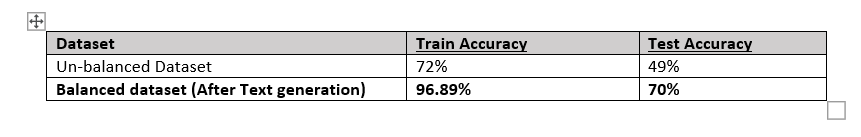